In [1]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 7.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910454 sha256=154571b98be707d81aa5b95842ca9799bdd3a574111550ae32d92094080eb141
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch_geometric


In [2]:
import torch
import torch_geometric

In [3]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

Processing...
Done!


In [4]:
# Get some basic info about the dataset
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
print(50*'=')

# There is only one graph in the dataset, use it as new data object
data = dataset[0]

# Gather some statistics about the graph.
print(data)
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Number of validation nodes: {data.val_mask.sum()}')
print(f'Number of test nodes: {data.test_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Validation node label rate: {int(data.val_mask.sum()) / data.num_nodes:.2f}')
print(f'Testing node label rate: {int(data.test_mask.sum()) / data.num_nodes:.2f}')
print(f'Is undirected: {data.is_undirected()}')

Number of graphs: 1
Number of features: 1433
Number of classes: 7
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Number of training nodes: 140
Number of validation nodes: 500
Number of test nodes: 1000
Training node label rate: 0.05
Validation node label rate: 0.18
Testing node label rate: 0.37
Is undirected: True


In [5]:
print(data.x.shape),data.x[0][:100]

torch.Size([2708, 1433])


(None,
 tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.1111, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.1111, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]))

In [6]:
data.y

tensor([3, 4, 4,  ..., 3, 3, 3])

In [7]:
data.edge_index.t()

tensor([[   0,  633],
        [   0, 1862],
        [   0, 2582],
        ...,
        [2707,  598],
        [2707, 1473],
        [2707, 2706]])

In [8]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

In [9]:
class GCN(nn.Module):
  def __init__(self,hidden_channels):
    super().__init__()
    self.conv1 = GCNConv(dataset.num_features,hidden_channels)
    self.conv2 = GCNConv(hidden_channels,hidden_channels)
    self.out = nn.Linear(hidden_channels,dataset.num_classes)

  def forward(self,x,edge_index):
    # transformation layer
    x = self.conv1(x,edge_index)
    x = x.relu()
    x = F.dropout(x,p=0.5,training = self.training)
    # message passing layer
    x = self.conv2(x,edge_index)
    x = x.relu()
    x = F.dropout(x,p=0.5,training = self.training)
    # Output Layer
    x = F.softmax(self.out(x), dim=1)
    return x

In [10]:
model = GCN(hidden_channels=128)
model

GCN(
  (conv1): GCNConv(1433, 128)
  (conv2): GCNConv(128, 128)
  (out): Linear(in_features=128, out_features=7, bias=True)
)

In [14]:
from torch_geometric.data import DataLoader
device=torch.device('cuda' if torch.cuda.is_available() else "cpu")
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                           lr=0.005,
                           weight_decay=5e-4)
data=data.to(device)
model = model.to(device)
data_size = len(data)

In [15]:
def train():
  model.train()
  optimizer.zero_grad()
  out = model(data.x,data.edge_index)
  loss = criterion(out[data.train_mask],data.y[data.train_mask])
  loss.backward()
  optimizer.step()
  return loss

def test():
  model.eval()
  optimizer.zero_grad()
  out = model(data.x,data.edge_index)
  pred = out.argmax(dim=1)
  test_pred = pred[data.test_mask] == data.y[data.test_mask]
  test_acc = int(test_pred.sum())/int(data.test_mask.sum())
  return test_acc

In [16]:
losses = []
for epoch in range(2000):
  loss = train()
  losses.append(loss)
  if(epoch % 200 == 0):
    print(f'Epoch {epoch} | Train_loss : {loss}')

Epoch 0 | Train_loss : 1.945890188217163
Epoch 200 | Train_loss : 1.2199786901474
Epoch 400 | Train_loss : 1.1964006423950195
Epoch 600 | Train_loss : 1.2021377086639404
Epoch 800 | Train_loss : 1.205834984779358
Epoch 1000 | Train_loss : 1.199505090713501
Epoch 1200 | Train_loss : 1.1975311040878296
Epoch 1400 | Train_loss : 1.1942799091339111
Epoch 1600 | Train_loss : 1.2009042501449585
Epoch 1800 | Train_loss : 1.1980431079864502


<Axes: >

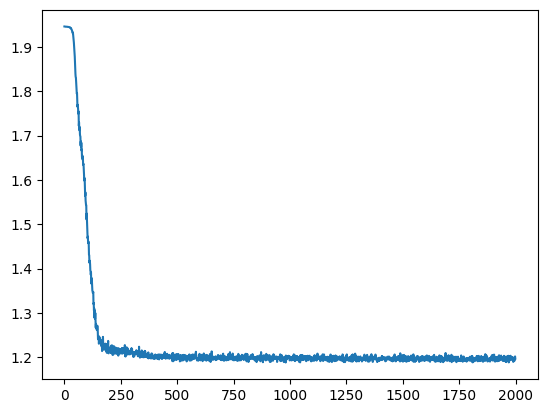

In [17]:
import seaborn as sns
losses_float = [float(loss.cpu().detach().numpy()) for loss in losses]
loss_indices = [i for i,l in enumerate(losses_float)]
sns.lineplot(x=loss_indices,y=losses_float)

In [18]:
test_acc = test()
print(test_acc)

0.759


<Axes: >

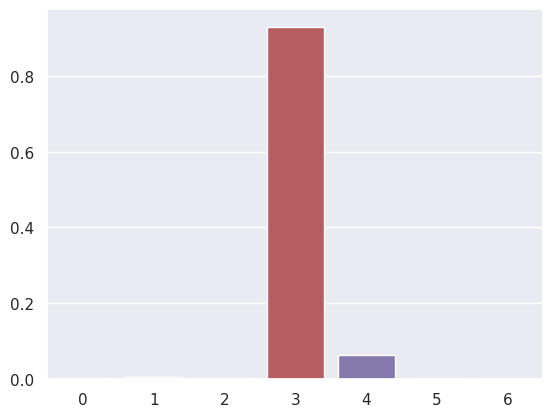

In [19]:
import numpy as np
sample = 1000
sns.set_theme(style='darkgrid')
pred = model(data.x,data.edge_index)
sns.barplot(x=np.array(range(7)), y=pred[len(pred)-1].detach().cpu().numpy())

In [29]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def plt2arr(fig):
  rgb_str = fig.canvas.tostring_rgb()
  (w,h) = fig.canvas.get_width_height()
  rgb_arr = np.fromstring(rgb_str , dtype=np.uint8, sep='').reshape((w,h,-1))
  return rgb_arr

def visualize(out , color , epoch):
  fig = plt.figure(figsize=(5,5),frameon=False)
  fig.suptitle(f'Epoch = {epoch}')
  z = TSNE(n_components = 2).fit_transform(out.detach().cpu().numpy())
  plt.xticks([])
  plt.yticks([])
  plt.scatter(z[:,0],
              z[:,1],
              s =70,
              c=color.detach().cpu().numpy(),
              cmap="Set2")
  fig.canvas.draw()

  return plt2arr(fig)

In [30]:
import warnings
warnings.filterwarnings('ignore')

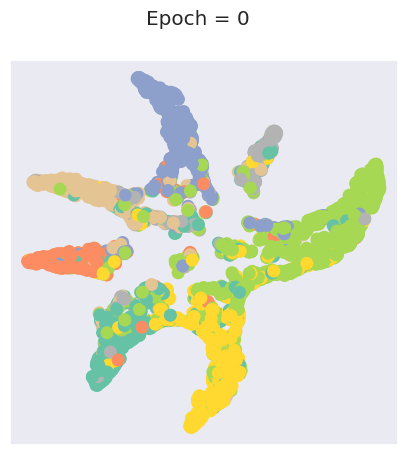

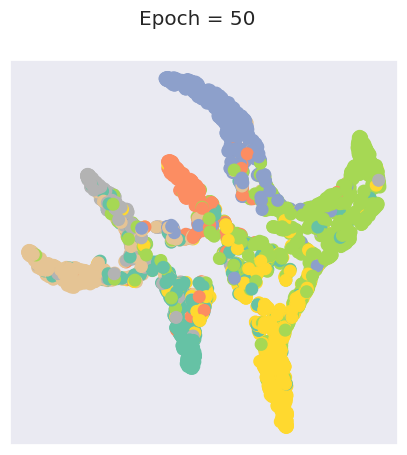

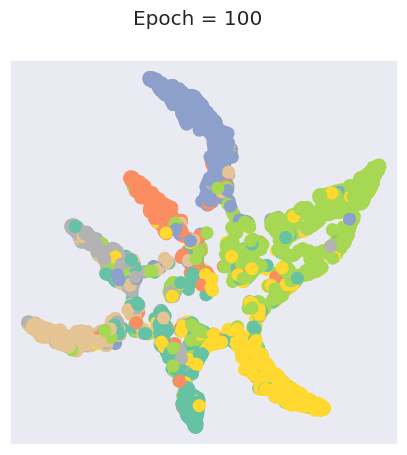

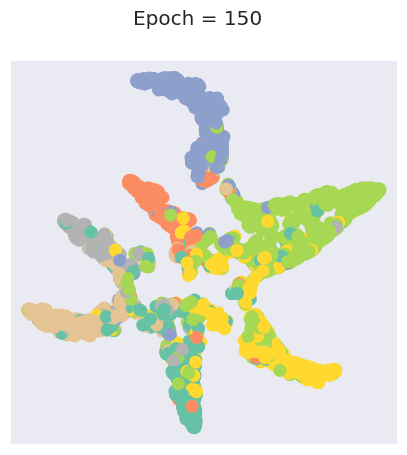

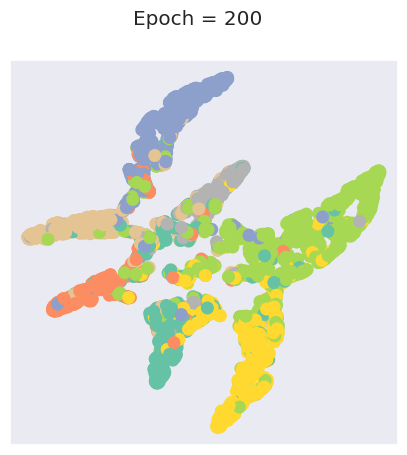

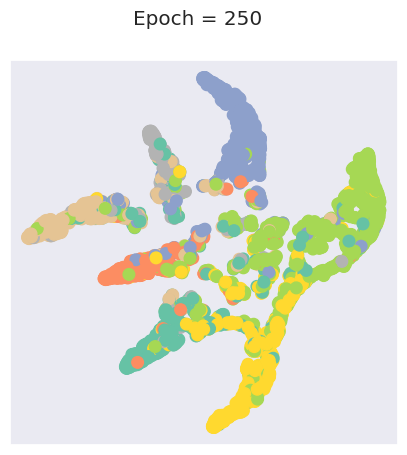

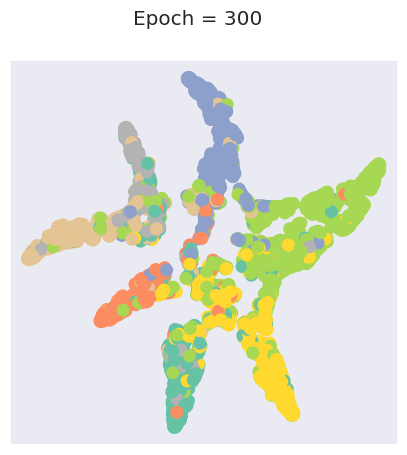

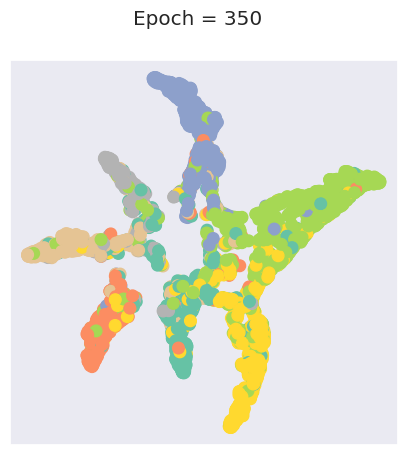

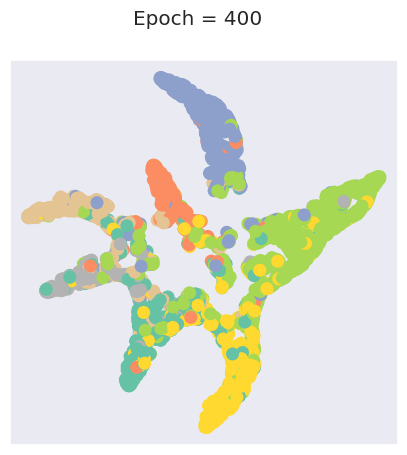

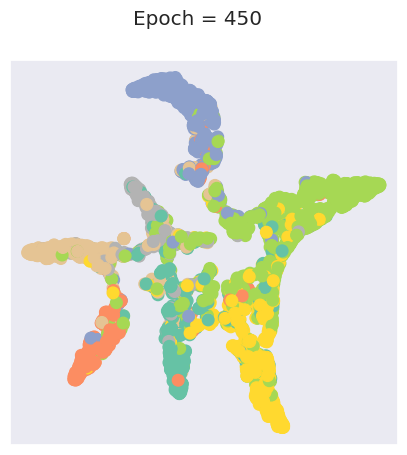

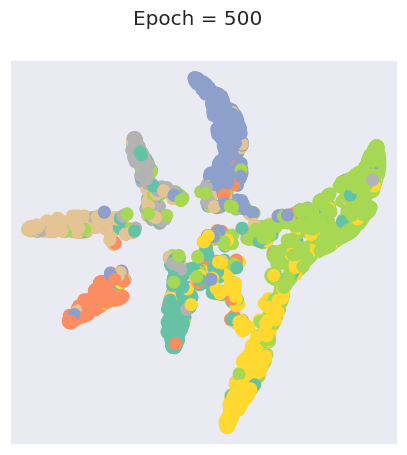

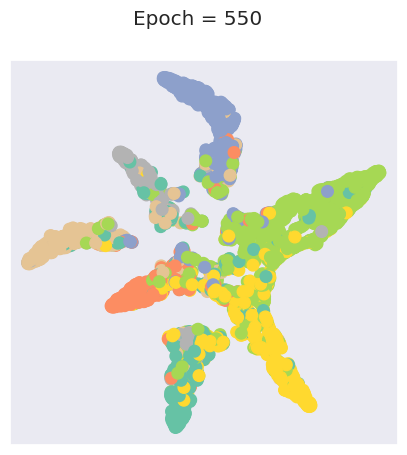

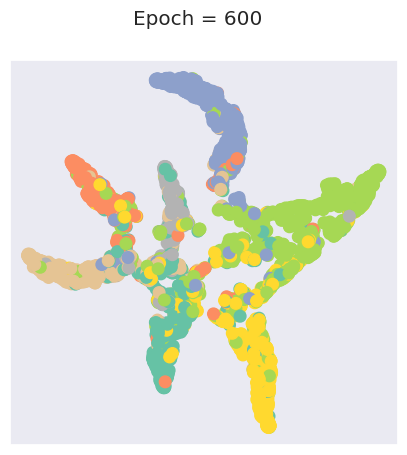

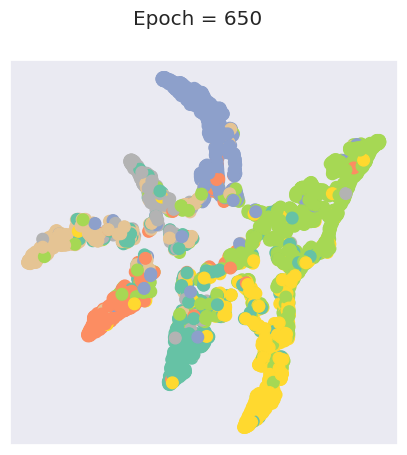

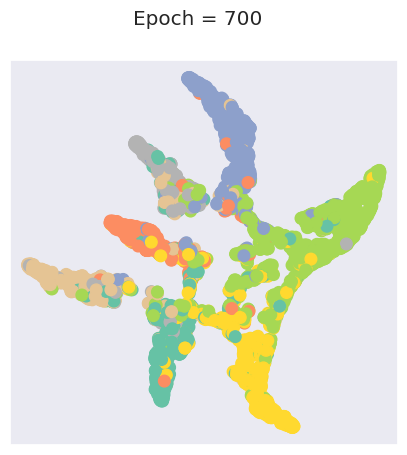

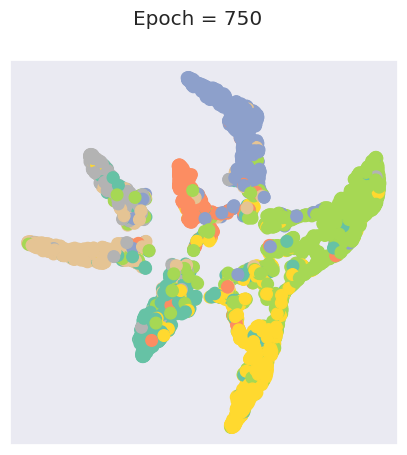

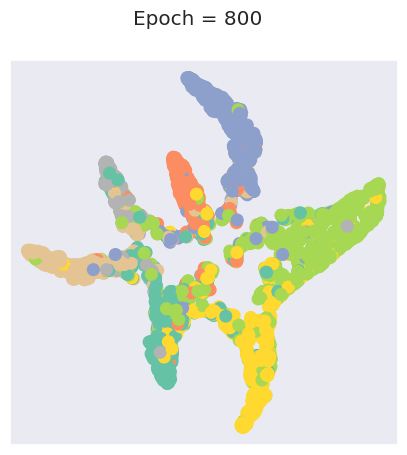

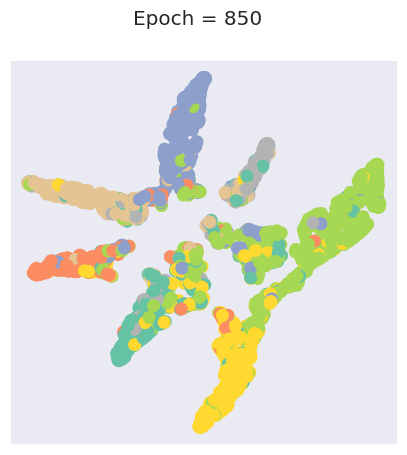

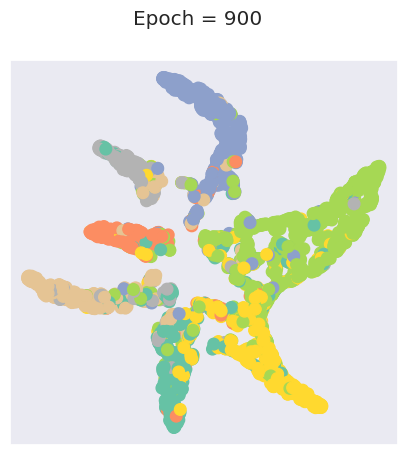

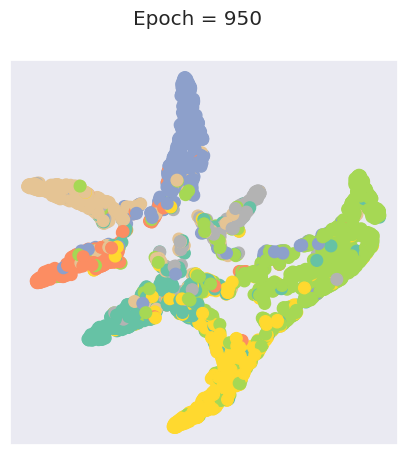

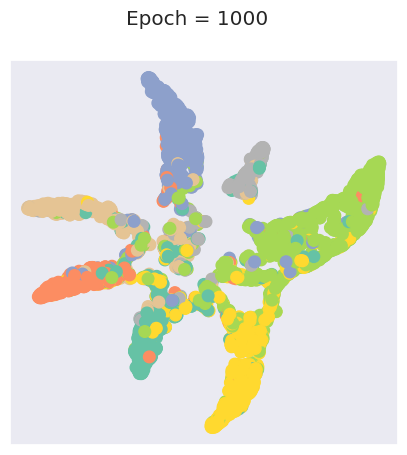

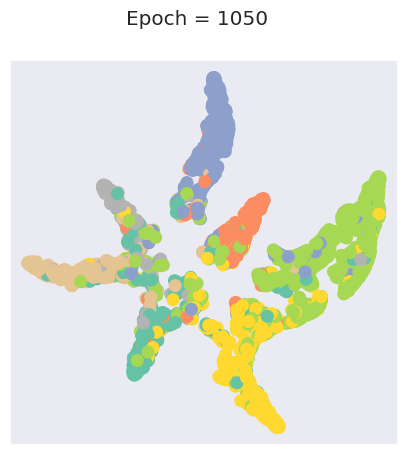

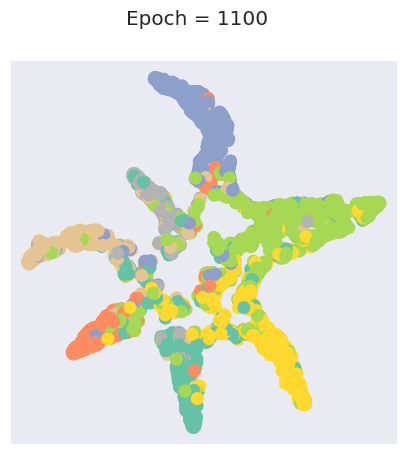

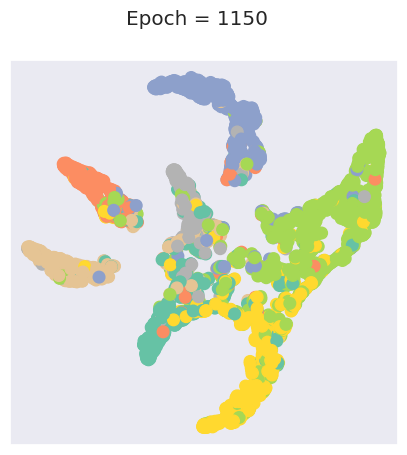

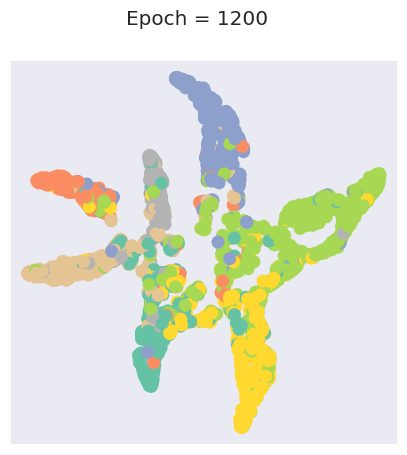

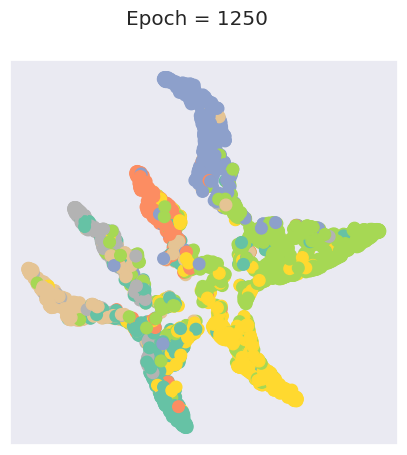

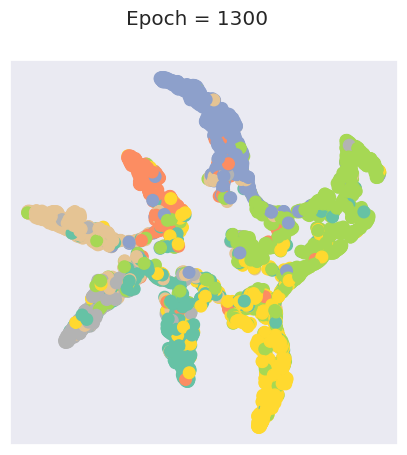

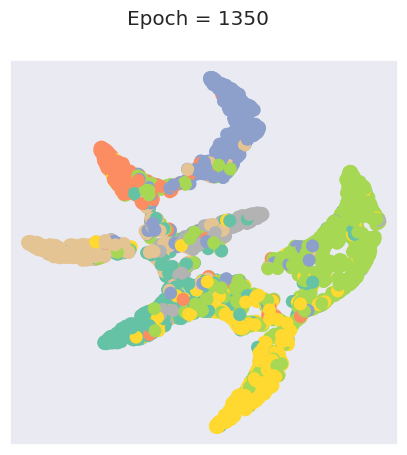

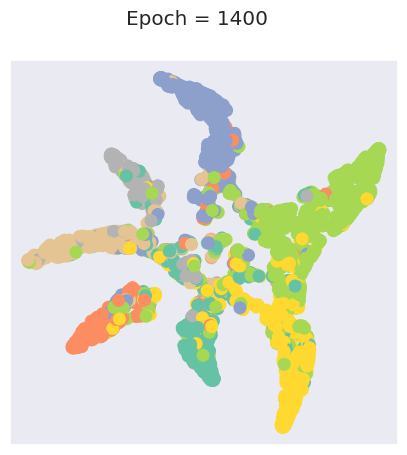

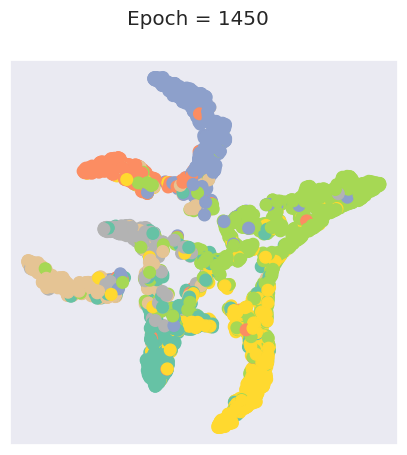

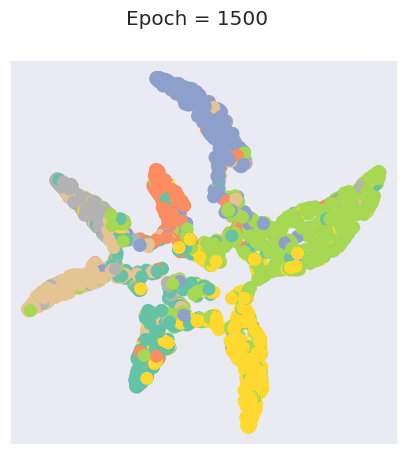

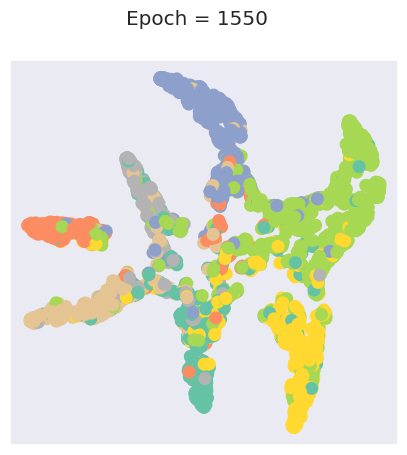

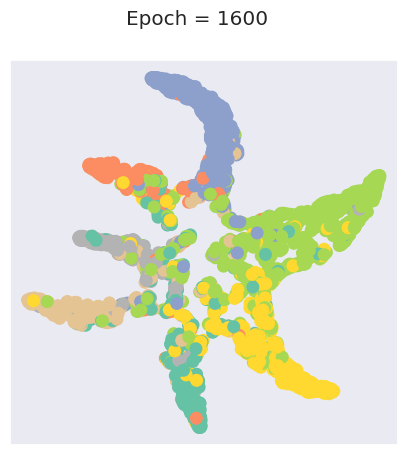

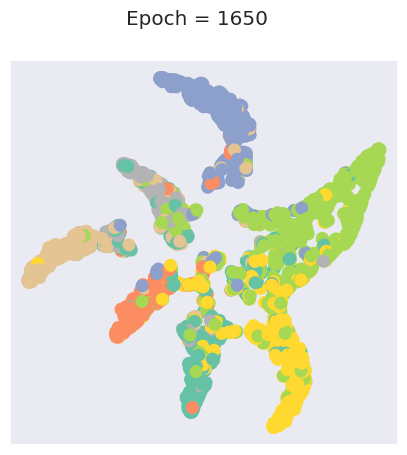

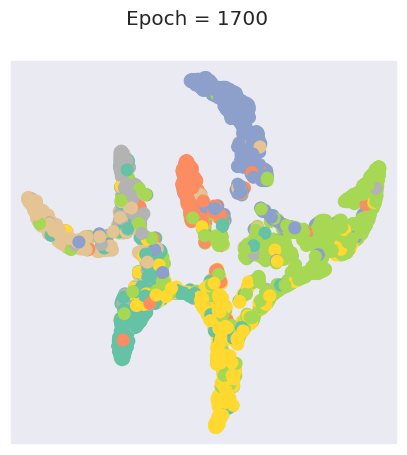

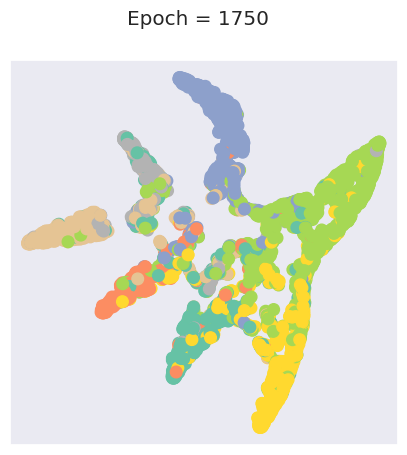

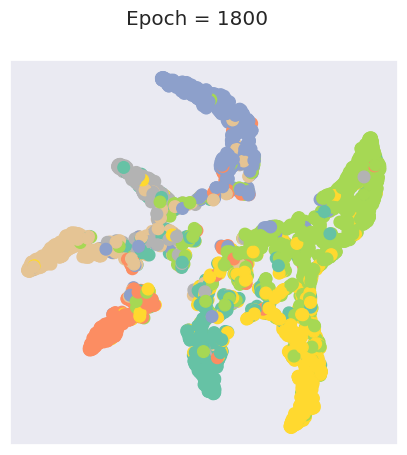

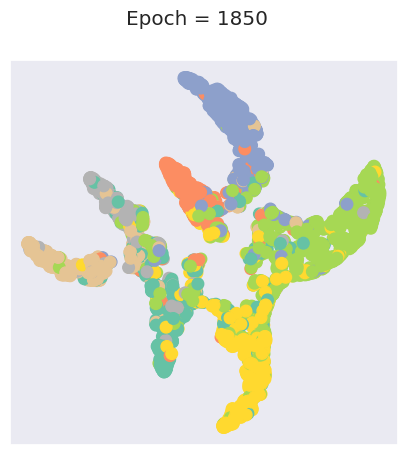

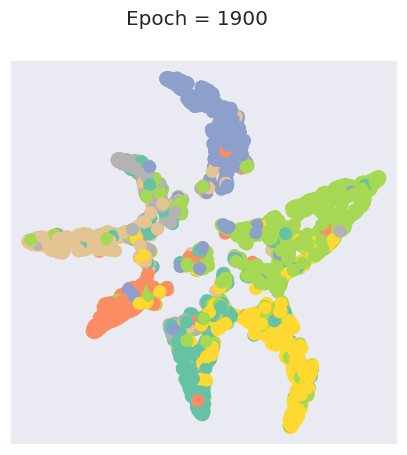

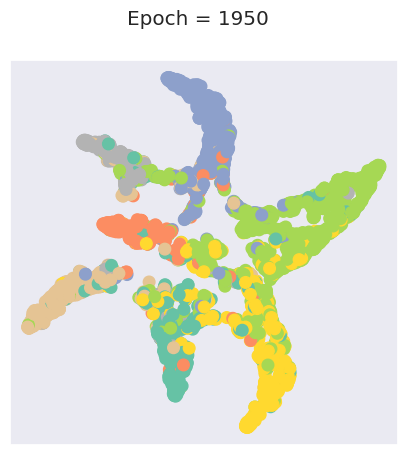

In [31]:
images = []
for epoch in range(2000):
  loss = train()
  if(epoch % 50 == 0):
    out = model(data.x,data.edge_index)
    images.append(visualize(out,color=data.y,epoch=epoch))

In [32]:
from moviepy.editor import ImageSequenceClip
fps = 1
filename = "/content/embeddings.gif"
clip = ImageSequenceClip(images, fps=fps)
clip.write_gif(filename, fps=fps)

MoviePy - Building file /content/embeddings.gif with imageio.


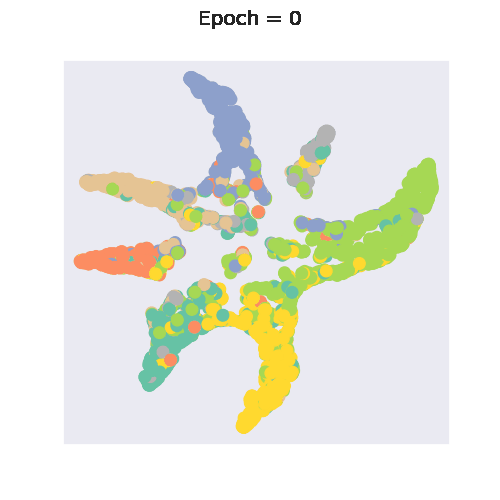

In [33]:
from IPython.display import Image
with open('/content/embeddings.gif','rb') as f:
  display(Image(data=f.read(),format='png'))